In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [3]:
# Load the dataset
file_path = 'data_balita.csv'
data = pd.read_csv(file_path)

# Display basic information about the dataset
dataset_info = {
    'Number of Rows': data.shape[0],
    'Number of Columns': data.shape[1],
    'Column Names': data.columns.tolist(),
    'Data Types': data.dtypes.to_dict()
}

dataset_info

{'Number of Rows': 120999,
 'Number of Columns': 4,
 'Column Names': ['Umur (bulan)',
  'Jenis Kelamin',
  'Tinggi Badan (cm)',
  'Status Gizi'],
 'Data Types': {'Umur (bulan)': dtype('int64'),
  'Jenis Kelamin': dtype('O'),
  'Tinggi Badan (cm)': dtype('float64'),
  'Status Gizi': dtype('O')}}

In [4]:
# Basic exploration and summary statistics
missing_values = data.isnull().sum()
summary_numerical = data.describe()
summary_categorical = data.describe(include='object')

missing_values, summary_numerical, summary_categorical



(Umur (bulan)         0
 Jenis Kelamin        0
 Tinggi Badan (cm)    0
 Status Gizi          0
 dtype: int64,
         Umur (bulan)  Tinggi Badan (cm)
 count  120999.000000      120999.000000
 mean       30.173803          88.655434
 std        17.575119          17.300997
 min         0.000000          40.010437
 25%        15.000000          77.000000
 50%        30.000000          89.800000
 75%        45.000000         101.200000
 max        60.000000         128.000000,
        Jenis Kelamin Status Gizi
 count         120999      120999
 unique             2           4
 top        perempuan      normal
 freq           61002       67755)

In [5]:
# Renaming the columns to English
data.rename(columns={
    'Umur (bulan)': 'Age (months)',
    'Jenis Kelamin': 'Gender',
    'Tinggi Badan (cm)': 'Height (cm)',
    'Status Gizi': 'Nutritional Status'
}, inplace=True)

# Display the first few rows to confirm the changes
data.head()



,Age (months),Gender,Height (cm),Nutritional Status
0,0,laki-laki,44.591973,stunted
1,0,laki-laki,56.705203,tinggi
2,0,laki-laki,46.863358,normal
3,0,laki-laki,47.508026,normal
4,0,laki-laki,42.743494,severely stunted


In [6]:
# Checking unique values for categorical columns and translating them to English
unique_values_gender = data['Gender'].unique()
unique_values_nutritional_status = data['Nutritional Status'].unique()

# Translating Indonesian gender and nutritional status terms to English
translation_map = {
    'laki-laki': 'male',
    'perempuan': 'female',
    'stunted': 'stunted',
    'tinggi': 'tall',
    'normal': 'normal',
    'severely stunted': 'severely stunted'
}

data['Gender'] = data['Gender'].map(translation_map)
data['Nutritional Status'] = data['Nutritional Status'].map(translation_map)

unique_values_gender_translated = data['Gender'].unique()
unique_values_nutritional_status_translated = data['Nutritional Status'].unique()

unique_values_gender_translated, unique_values_nutritional_status_translated



(array(['male', 'female'], dtype=object),
 array(['stunted', 'tall', 'normal', 'severely stunted'], dtype=object))

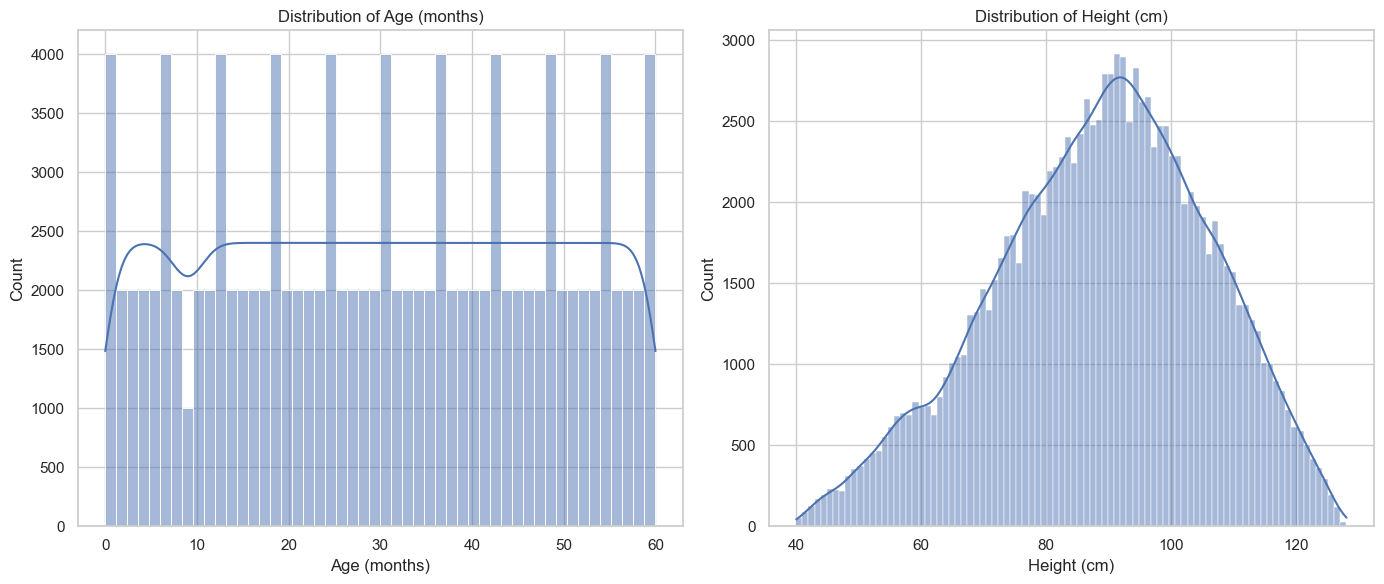

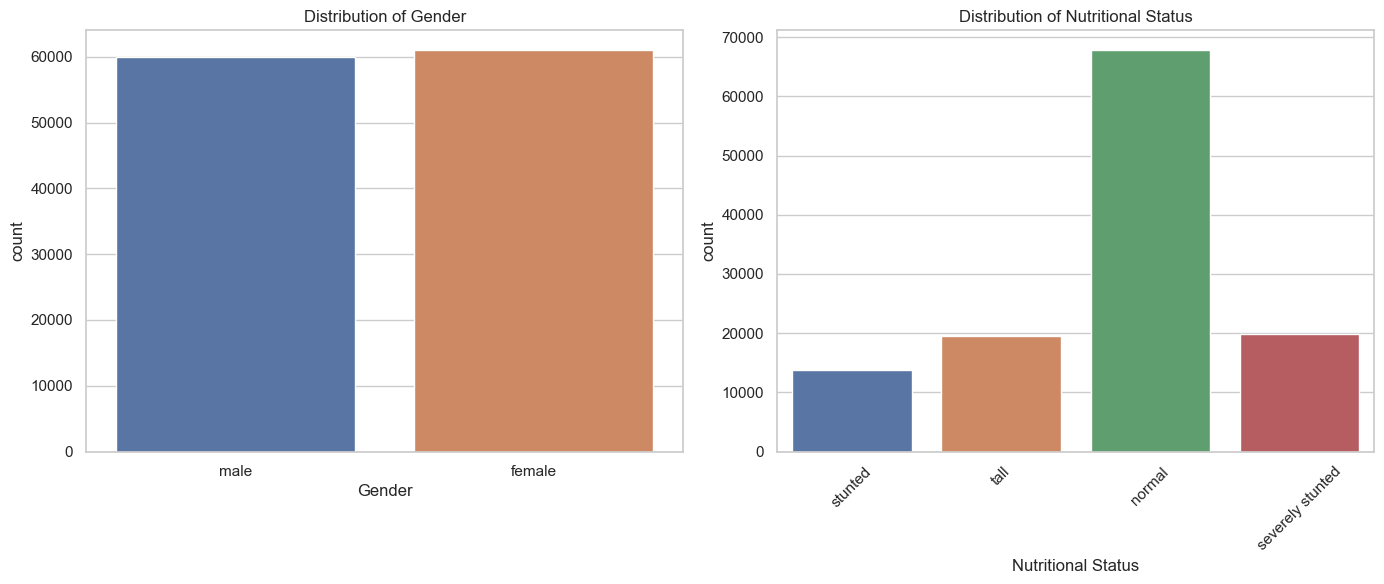

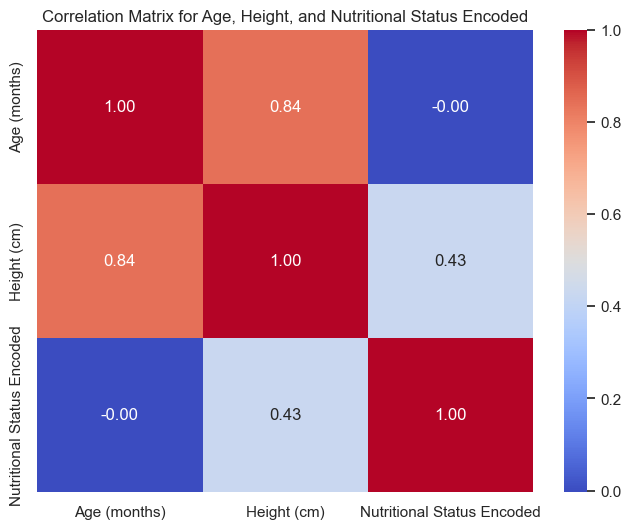

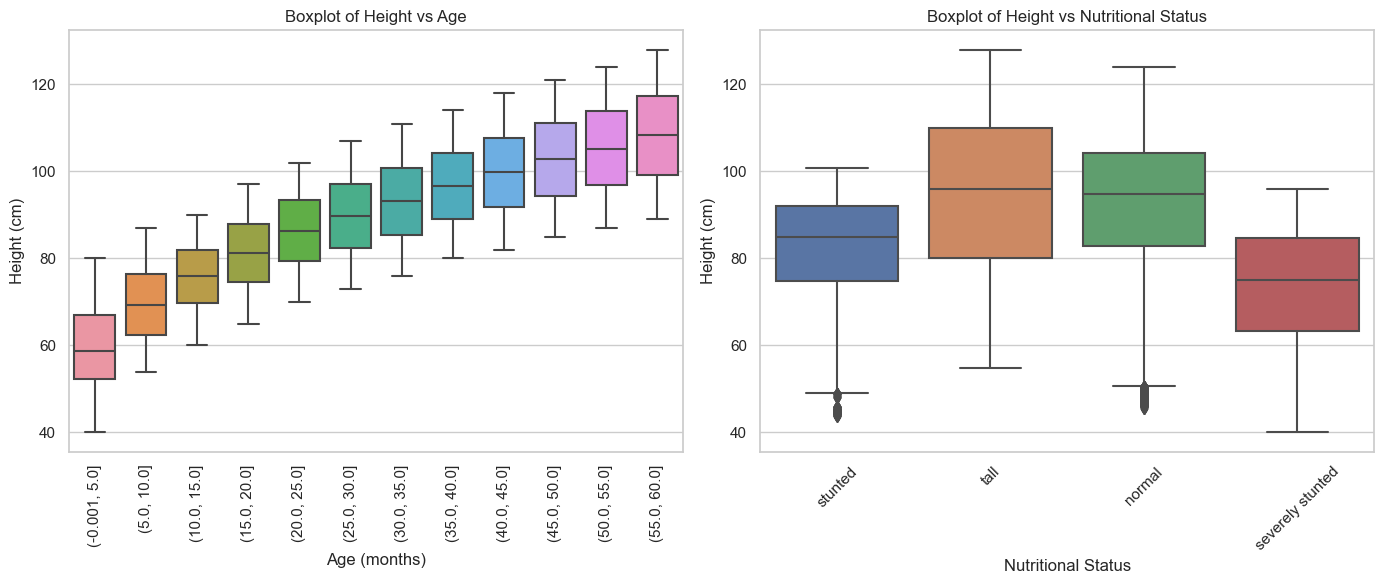

In [7]:
# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Distribution analysis for numerical variables
plt.figure(figsize=(14, 6))

# Plot for Age distribution
plt.subplot(1, 2, 1)
sns.histplot(data['Age (months)'], kde=True)
plt.title('Distribution of Age (months)')

# Plot for Height distribution
plt.subplot(1, 2, 2)
sns.histplot(data['Height (cm)'], kde=True)
plt.title('Distribution of Height (cm)')

plt.tight_layout()
plt.savefig('distribution_analysis.png')  # Save the figure
plt.show()

# Categorical data analysis for Gender and Nutritional Status
plt.figure(figsize=(14, 6))

# Plot for Gender distribution
plt.subplot(1, 2, 1)
sns.countplot(x='Gender', data=data)
plt.title('Distribution of Gender')

# Plot for Nutritional Status distribution
plt.subplot(1, 2, 2)
sns.countplot(x='Nutritional Status', data=data)
plt.xticks(rotation=45)
plt.title('Distribution of Nutritional Status')

plt.tight_layout()
plt.savefig('categorical_data_analysis.png')  # Save the figure
plt.show()

# Encoding Nutritional Status for correlation analysis
nutritional_status_encoding = {'severely stunted': 1, 'stunted': 2, 'normal': 3, 'tall': 4}
data['Nutritional Status Encoded'] = data['Nutritional Status'].map(nutritional_status_encoding)

# Correlation matrix and heatmap
correlation_matrix = data[['Age (months)', 'Height (cm)', 'Nutritional Status Encoded']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix for Age, Height, and Nutritional Status Encoded')

plt.savefig('correlation_matrix.png')  # Save the figure
plt.show()

# Boxplots for Height vs Age and Nutritional Status
plt.figure(figsize=(14, 6))

# Create buckets of 5 for 'Age (months)'
data['Age (months)'] = pd.cut(data['Age (months)'], bins=range(0, data['Age (months)'].max() + 5, 5), include_lowest=True)

# Boxplot of Height vs Age
plt.subplot(1, 2, 1)
sns.boxplot(x='Age (months)', y='Height (cm)', data=data)
plt.xticks(rotation=90)
plt.title('Boxplot of Height vs Age')

# Boxplot of Height vs Nutritional Status
plt.subplot(1, 2, 2)
sns.boxplot(x='Nutritional Status', y='Height (cm)', data=data)
plt.xticks(rotation=45)
plt.title('Boxplot of Height vs Nutritional Status')

plt.tight_layout()
plt.savefig('boxplots.png')  # Save the figure
plt.show()

In [8]:
from scipy.stats import ttest_ind

# Separate the data into groups
male_height = data[data['Gender'] == 'male']['Height (cm)']
female_height = data[data['Gender'] == 'female']['Height (cm)']

# Perform t-test
t_stat_gender, p_value_gender = ttest_ind(male_height, female_height)

# T-test results for gender comparison
t_stat_gender, p_value_gender



(10.543669862136134, 5.576622331152575e-26)

In [9]:
# Separate the data into groups for nutritional status
normal_height = data[data['Nutritional Status'] == 'normal']['Height (cm)']
stunted_height = data[data['Nutritional Status'] == 'stunted']['Height (cm)']

# Perform t-test
t_stat_nutrition, p_value_nutrition = ttest_ind(normal_height, stunted_height)

# T-test results for nutritional status comparison
t_stat_nutrition, p_value_nutrition



(74.07203950002678, 0.0)

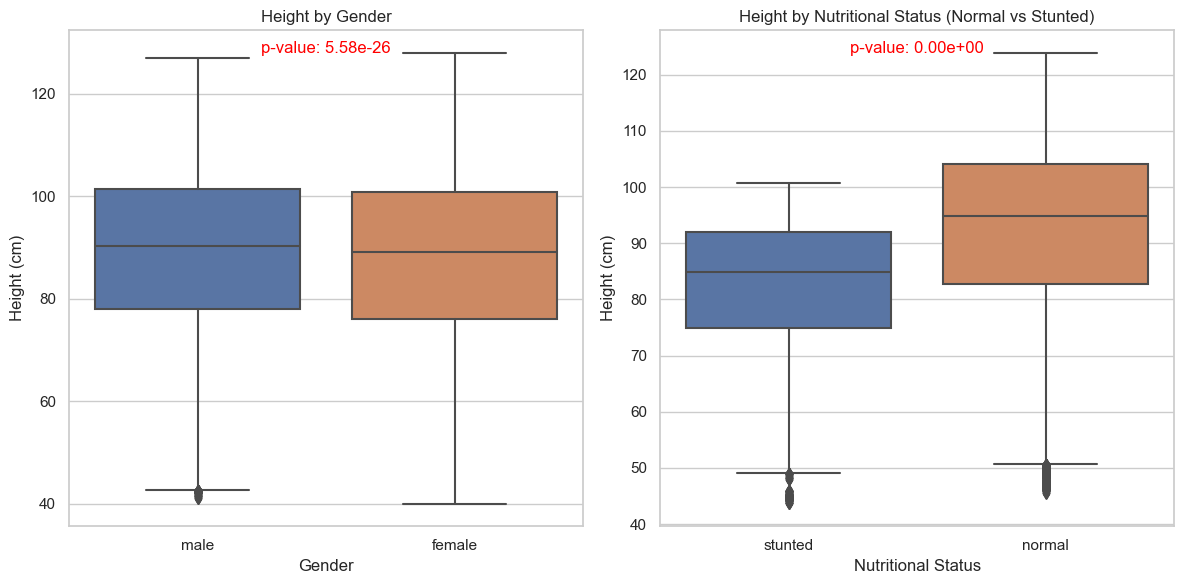

In [26]:
# Creating boxplots for visualization

# Boxplot for Height by Gender with p-value
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.boxplot(x='Gender', y='Height (cm)', data=data)
plt.title('Height by Gender')
plt.text(0.5, max(data['Height (cm)']), f'p-value: {p_value_gender:.2e}', 
         horizontalalignment='center', fontsize=12, color='red')

# Boxplot for Height by Nutritional Status (Normal vs Stunted) with p-value
normal_stunted_data = data[data['Nutritional Status'].isin(['normal', 'stunted'])]
plt.subplot(1, 2, 2)
sns.boxplot(x='Nutritional Status', y='Height (cm)', data=normal_stunted_data)
plt.title('Height by Nutritional Status (Normal vs Stunted)')
plt.text(0.5, max(normal_stunted_data['Height (cm)']), f'p-value: {p_value_nutrition:.2e}', 
         horizontalalignment='center', fontsize=12, color='red')

plt.tight_layout()
plt.savefig('boxplots_with_p_value.png')  # Save the figure
plt.show()



Height by Gender:

The boxplot shows a clear difference in the height distribution between males and females.
The p-value (5.58×10−26) is annotated on the plot, indicating a statistically significant difference between the two groups.

Height by Nutritional Status (Normal vs Stunted):

The height distributions for children with normal and stunted nutritional statuses are distinctly different.
The p-value is effectively zero, as annotated on the plot, highlighting a highly significant difference in height between these two nutritional status groups.

In [11]:
from scipy.stats import f_oneway

# Preparing data for ANOVA test
groups = data.groupby('Nutritional Status')['Height (cm)'].apply(list)

# Perform ANOVA test
anova_result = f_oneway(*groups)

# ANOVA test results
anova_result

F_onewayResult(statistic=10025.708484949704, pvalue=0.0)

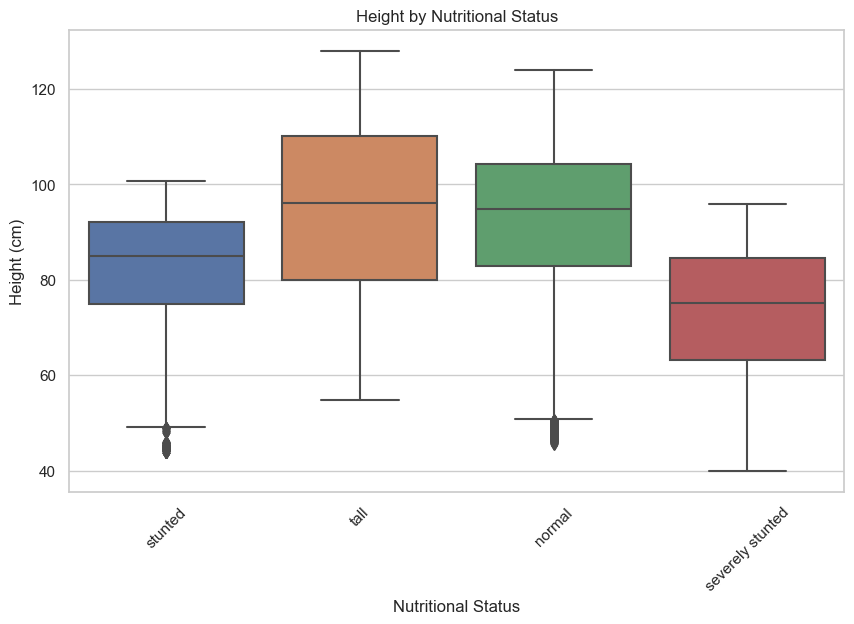

In [25]:
# Boxplot for Height by Nutritional Status with all categories
plt.figure(figsize=(10, 6))
sns.boxplot(x='Nutritional Status', y='Height (cm)', data=data)
plt.title('Height by Nutritional Status')
plt.xticks(rotation=45)
plt.savefig('boxplot_all_categories.png')  # Save the figure
plt.show()



The boxplot illustrates the height distribution across the different nutritional status categories:

There are clear differences in the median and range of heights among the categories.

Children categorized as 'tall' have the highest median height, followed by those with 'normal', 'stunted', and 'severely stunted' statuses.

The variation in height within each category is also evident, with 'normal' and 'stunted' categories showing a wide range of heights.

In [13]:
# Convert 'Age (months)' from intervals to midpoints of intervals
data['Age (months)'] = data['Age (months)'].apply(lambda x: x.mid).astype(float)

# Now we proceed with the one-hot encoding and regression analysis as before
encoder = OneHotEncoder(sparse=False)
encoded_categorical = encoder.fit_transform(data[['Gender', 'Nutritional Status']])

# Creating a new DataFrame with encoded categorical features and the numerical feature (Age)
encoded_data = pd.DataFrame(encoded_categorical, 
                            columns=encoder.get_feature_names_out(['Gender', 'Nutritional Status']))
encoded_data['Age (months)'] = data['Age (months)']

# Target variable
target = data['Height (cm)']

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(encoded_data, target, test_size=0.2, random_state=42)

# Model development
model = LinearRegression()
model.fit(X_train, y_train)

# Predicting on the test set
y_pred = model.predict(X_test)

# Model evaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R-squared Score:", r2)


Mean Squared Error: 32.61172949259357
R-squared Score: 0.8915327749101125


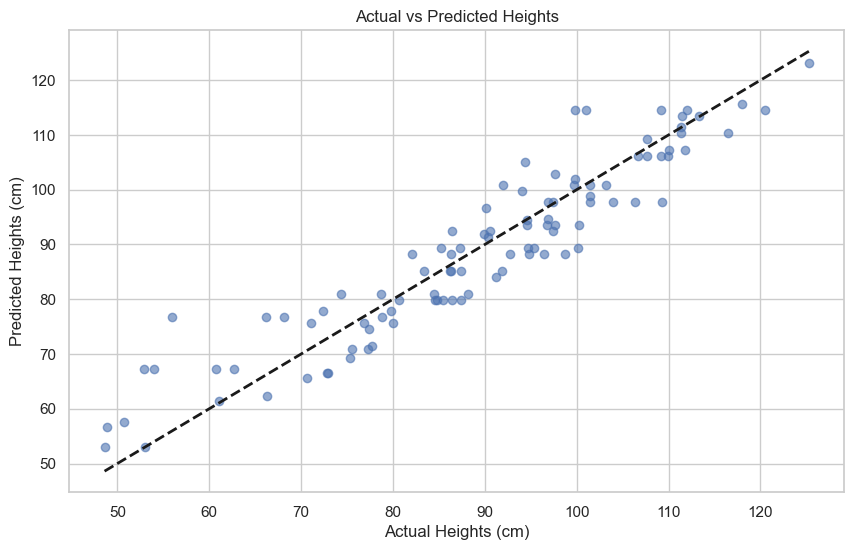

In [24]:
# Generating predictions using the model
sample_data = X_test.sample(100, random_state=42)  # Selecting a sample for visualization
actual_heights = y_test.loc[sample_data.index]     # Corresponding actual heights
predicted_heights = model.predict(sample_data)     # Predicted heights

# Visualization of Predictions vs Actual Values
plt.figure(figsize=(10, 6))
plt.scatter(actual_heights, predicted_heights, alpha=0.6)
plt.xlabel('Actual Heights (cm)')
plt.ylabel('Predicted Heights (cm)')
plt.title('Actual vs Predicted Heights')
plt.plot([actual_heights.min(), actual_heights.max()], [actual_heights.min(), actual_heights.max()], 'k--', lw=2)  # Diagonal line
plt.savefig('predictions_vs_actual.png')  # Save the figure
plt.show()



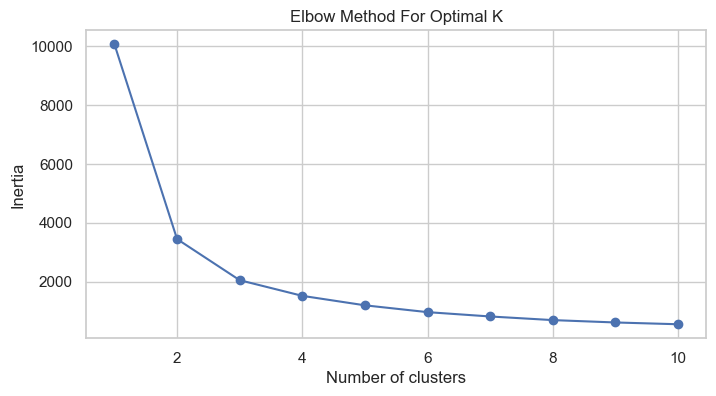

In [23]:
# Data preparation for clustering - using 'Age (months)' and 'Height (cm)'
clustering_data = data[['Age (months)', 'Height (cm)']]

# Standardizing the data
scaler = StandardScaler()
clustering_data_scaled = scaler.fit_transform(clustering_data)

# Using a representative sample for the Elbow method
sample_size = 5000  # Adjust based on your dataset size
clustering_data_sample = clustering_data.sample(sample_size, random_state=42)
clustering_data_sample_scaled = scaler.transform(clustering_data_sample)

# Elbow method to determine the optimal number of clusters
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(clustering_data_sample_scaled)
    inertia.append(kmeans.inertia_)

# Plotting the Elbow method result
plt.figure(figsize=(8, 4))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method For Optimal K')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.savefig('elbow_method.png')  # Save the figure
plt.show()


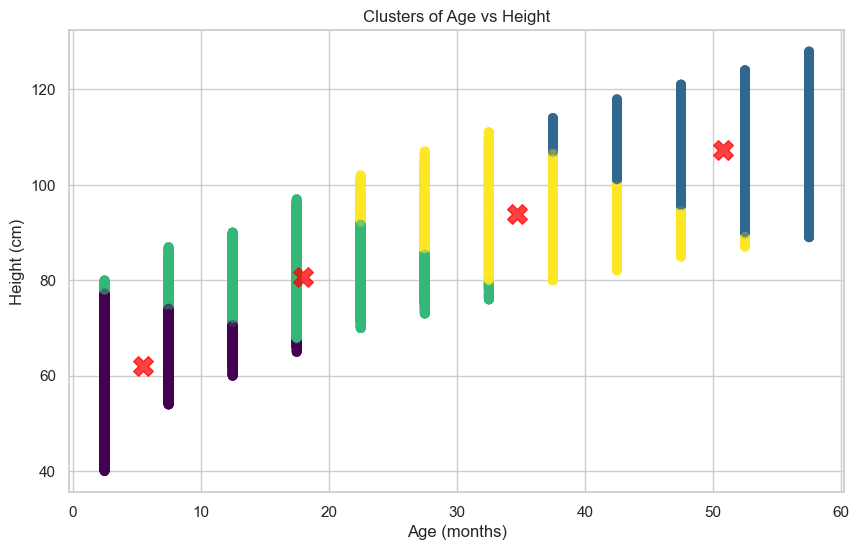

In [22]:
# Fit K-means using the optimal number of clusters 
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans.fit(clustering_data_scaled)

# Predicting the cluster labels
labels = kmeans.predict(clustering_data_scaled)

# Visualization of clusters
plt.figure(figsize=(10, 6))
plt.scatter(clustering_data['Age (months)'], clustering_data['Height (cm)'], c=labels, cmap='viridis', alpha=0.5)
plt.xlabel('Age (months)')
plt.ylabel('Height (cm)')
plt.title('Clusters of Age vs Height')
centers = scaler.inverse_transform(kmeans.cluster_centers_)
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.75, marker='X')  # Marking the cluster centers
plt.savefig('clusters.png')  # Save the figure
plt.show()


The scatter plot visualizes the clustering of children's heights versus their ages, demonstrating distinct groupings that correspond to different growth patterns. Three main clusters are discernible, each marked by a red 'X' indicating the centroid of the respective cluster.

The first cluster, represented in green, contains younger children, primarily ranging from infancy to around 10 months. The heights in this cluster are generally the lowest, reflecting the expected growth trajectory at this early stage of development.

The second cluster, shown in blue, spans a broader age range, approximately from 10 to 30 months. This cluster represents a transition phase of growth, where children typically experience significant developmental progress. The heights in this cluster are more varied, which can be attributed to the different rates at which children grow during these months.

The third cluster, colored in yellow, includes children from around 30 to 60 months. This cluster has the highest average height, aligning with the natural increase in height as children grow older. It's notable that the variance in height within this group is also greater, suggesting a wide range of growth patterns that could be influenced by genetic and environmental factors.

The positioning of the cluster centroids (red 'X's) provides a reference for the average height within each age group. The centroids move upward and to the right, which visually confirms that as age increases, so does height.

These clusters could inform pediatric growth studies by highlighting typical growth patterns and identifying outliers. For healthcare professionals and policymakers, such insights are valuable for tailoring nutritional and health programs. Understanding these patterns can help in early detection of growth issues and ensure that interventions are targeted effectively. The analysis underscores the diversity of growth trajectories and the importance of considering age-specific baselines in pediatric health assessments.